In [157]:
from sys import path
from importlib import reload
import matplotlib.colors as mcolors
COLORS = list(mcolors.TABLEAU_COLORS.keys())
path.append('..')  # Go up one directory to where utils.py is located

In [158]:
import deeponet_utils, symp_utils
import symp_utils 
reload(deeponet_utils)
reload(symp_utils)
from deeponet_utils import *
from symp_utils import *

In [159]:

def get_data(num_iv=10, N=30, Tmax=1e-6, L=7, x0='random'):
    
    rho = lambda x, alpha : torch.sqrt(2 * alpha) / torch.cosh(torch.sqrt(alpha) * x)
    e = lambda x : torch.exp(1j * x)

    x = torch.linspace(-L, L, N)[None, :]
    t = torch.tensor(Tmax)
    
    
    if x0 == 'random':
        x0 = torch.rand(size=(num_iv, 1))
        
    else:
        x0 = torch.tensor([x0])[None,:]
        
    theta0, c, alpha = torch.zeros_like(x0), torch.ones_like(x0), torch.ones_like(x0)

    
    u0 = rho(x - x0, alpha) * e(c * (x - x0) / 2 + theta0)
    u = rho(x - c * t - x0, alpha) * e(c * (x - c*t - x0) / 2 + theta0) * e((alpha + c**2 / 4) * t)

    xi0 = torch.fft.fft(u0, axis=-1)
    xi = torch.fft.fft(u, axis=-1)
    
    y = (np.sqrt(2) * torch.imag(xi), np.sqrt(2) * torch.real(xi))
    X = (np.sqrt(2) * torch.imag(xi0), np.sqrt(2) * torch.real(xi0))
    
    params = (alpha, theta0, x0, c)
    
    return X, y, params



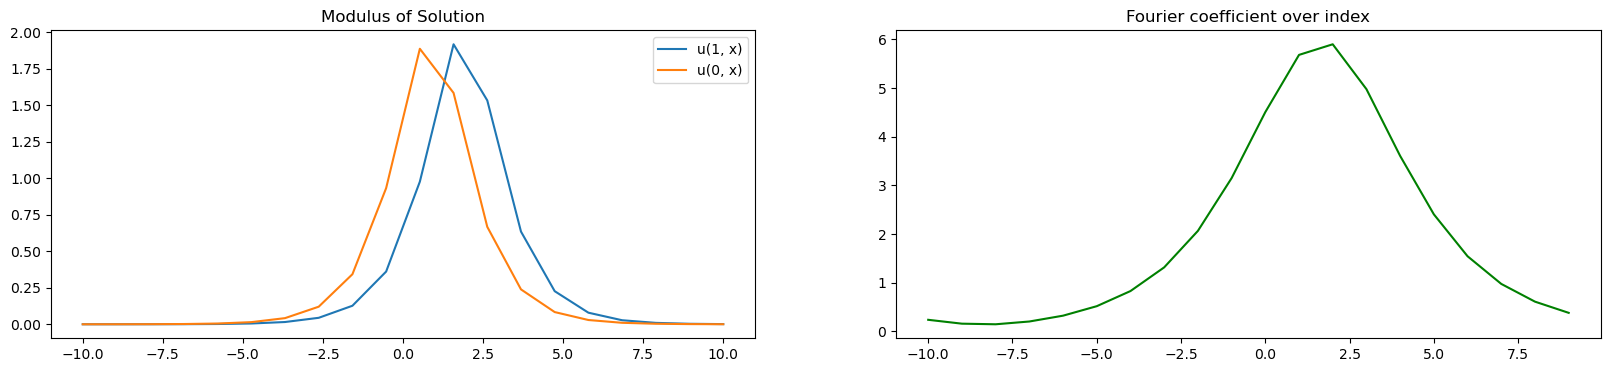

In [160]:
N, L, Tmax = 20, 10, 1
X, y, _ = get_data(num_iv=1, N=N, Tmax=Tmax, L=L)


xi = 1j * y[0][0,:] + y[1][0,:]
xi0 = 1j * X[0][0,:] + X[1][0,:]
x = torch.linspace(-L, L, N)


u = torch.fft.ifft(xi)
u0 = torch.fft.ifft(xi0)
xi = torch.fft.fftshift(xi)

k = torch.arange(N)

fig, ax = plt.subplots(1, 2, figsize=(20, 4))

ax[0].plot(x, torch.abs(u), label=f'u({Tmax}, x)')
ax[0].plot(x, torch.abs(u0), label='u(0, x)')
ax[0].set_title('Modulus of Solution')
ax[1].plot(np.arange(-N//2, N//2), torch.abs(xi), c='green')
ax[1].set_title('Fourier coefficient over index')
ax[0].legend()
plt.show()

In [161]:
N, h, L = 100, 1e-4, 10
X_train, y_train, _ = get_data(num_iv=100, Tmax=h, N=N, L=L)
X_test, y_test, _ = get_data(num_iv=100, Tmax=h, N=N, L=L)

print(y_test[1].shape)

print(*(np.mean(np.linalg.norm(y_train[i]-X_train[i])) for i in range(2)))

torch.Size([100, 100])
0.05763592 0.015013773


Step 	 Train loss 	 Test loss
1000 	 [6.68e-03] 	 [6.08e-03] 	 New best model!
2000 	 [5.09e-03] 	 [5.08e-03] 	 New best model!
3000 	 [5.02e-03] 	 [5.16e-03] 	 
4000 	 [4.77e-03] 	 [4.88e-03] 	 New best model!
5000 	 [4.82e-03] 	 [4.72e-03] 	 New best model!
6000 	 [4.67e-03] 	 [4.68e-03] 	 New best model!
7000 	 [4.58e-03] 	 [4.56e-03] 	 New best model!
8000 	 [4.83e-03] 	 [4.64e-03] 	 
9000 	 [4.54e-03] 	 [4.77e-03] 	 
10000 	 [4.78e-03] 	 [4.68e-03] 	 
Best testing loss: 0.004563790746033192


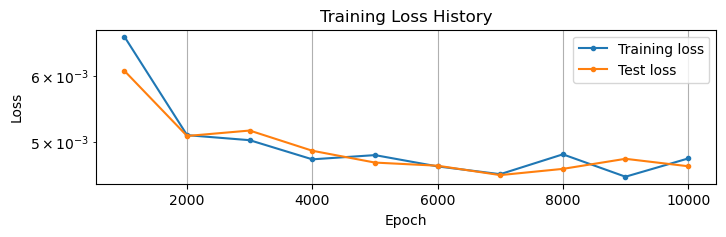

In [162]:
width, depth = 200, 3

net = SympNet(depth*[width], N=N, h=h, activation='tanh')
model = SympModel(X_train, y_train, X_test, y_test, net)
model.train(iterations=10_000)
model.plot_losshistory()

In [163]:
Tmax = 1
iters = int(Tmax / h)
T = h * (iters+1)
t = torch.linspace(0, T, iters+2)[:-1][None,:,None]
h_tensor = torch.tensor([[h]], dtype=torch.float32)


rho = lambda x, alpha : torch.sqrt(2 * alpha) / torch.cosh(torch.sqrt(alpha) * x)
e = lambda x : torch.exp(1j * x)

x = torch.tensor(np.linspace(-L, L, N))[None, None,:]

X, y, params = get_data(N=N,num_iv=1,Tmax=0,L=L,x0=0)

alpha, theta0, x0, c = params

true_u = (rho(x - c*t - x0, alpha) * e(c * (x - c*t - x0) / 2 + theta0) * e((alpha + c**2 / 4) * t)).squeeze(0).detach().numpy()
true_u_real, true_u_imag, true_u_abs = np.real(true_u), np.imag(true_u), np.abs(true_u)

q, p = model.predict(X, h, Tmax=Tmax)
xi = (p + 1j * q) / np.sqrt(2)
pred_u = torch.fft.ifft(xi).detach().numpy()
pred_u_real, pred_u_imag, pred_u_abs = np.real(pred_u), np.imag(pred_u), np.abs(pred_u)

X = x[0,0,:].numpy()


In [164]:
'''ANIMATE PREDICTION VS. SOLUTION'''
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML  # For rendering animations in Jupyter


step = np.max([int(0.01 / h), 1])

# Set up the figure and axis for plotting
fig, ax = plt.subplots(1, 3, figsize=(20, 4))
line1, = ax[0].plot(X, pred_u_real[0,:], '--', c='k')
line2, = ax[0].plot(X, true_u_real[0,:], c='orange', linewidth=10, alpha=0.3)
line3, = ax[1].plot(X, pred_u_imag[0,:], '--', c='k')
line4, = ax[1].plot(X, true_u_imag[0,:], c='blue', linewidth=10, alpha=0.3)
line5, = ax[2].plot(X, pred_u_abs[0,:], '--', c='k')
line6, = ax[2].plot(X, true_u_abs[0,:], c='green', linewidth=10, alpha=0.3)
time_text = ax[0].text(0, 1.07, f't={0}', transform=ax[0].transAxes, fontdict={'fontsize': 20, 'fontweight': 'bold'})

handles = [line2, line4, line6, line1]
labels = ['real(u)', 'imag(u)', 'abs(u)', 'prediction']
fig.legend(handles, labels, loc="upper center", ncol=len(labels), fontsize=10)

ax[0].set_ylim(-1, 2) 
ax[1].set_ylim(-1, 2)
ax[2].set_ylim(-1, 2)

# Define the update function for the animation
def update(frame):
    line1.set_ydata(pred_u_real[step*frame,:])
    line2.set_ydata(true_u_real[step*frame,:])
    line3.set_ydata(pred_u_imag[step*frame,:])
    line4.set_ydata(true_u_imag[step*frame,:])
    line5.set_ydata(pred_u_abs[step*frame,:])
    line6.set_ydata(true_u_abs[step*frame,:])
    time_text.set_text(f't={step*frame*h:.2f}, {step} {frame} ')  # Update the timer text

    return (line1, line2, line3, line4, time_text)

# Create the animation object
ani = FuncAnimation(fig, update, frames=pred_u.shape[0] // step, interval=50, blit=True)
# Display the animation inline in the notebook

plt.close(fig)

HTML(ani.to_jshtml())
